First, let's read the pre-processed data

In [1]:
%matplotlib inline
#set figure dpi to 100 to get reasonably sized figures displayed in the notebook
import matplotlib.pyplot as plt; plt.rc('figure', dpi=100)
import random
import os
import pandas as pd
import numpy as np
import seaborn as sns

# data_path = '../../data/TfT/MouseData_processed_merged/'
# measures_data_path = '../../data/TfT/MouseData_with_measures/'

data_path = '../../data/TfT/MouseTracking_P1-82_processed_merged'
measures_data_path = '../../data/TfT/MouseTracking_P1-82_with_measures/'

file_name = 'all_mouse_data.csv'
data = pd.read_csv(os.path.join(data_path, file_name)).set_index(['participant', 'trial_no'])

It's nice to have timestamp with respect to trial start. Also, we convert time from milliseconds to seconds (e.g., 5 to 0.005). Just in case, we keep original timestamps in `t_original`. 

In [2]:
data.loc[:, 't_original'] = data.t
data.loc[:, 't'] = data.t.groupby(['participant', 'trial_no']).transform(lambda t: (t-t.min())/1000.0)

Let's take a look at a random trajectory

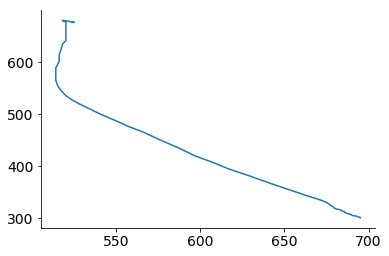

In [3]:
trial = random.choice(data.index)
trajectory = data.loc[trial]

plt.plot(trajectory.x, trajectory.y);

Next, let's plot a bunch of trajectories to get an idea of what's happening in terms of screen coordinates

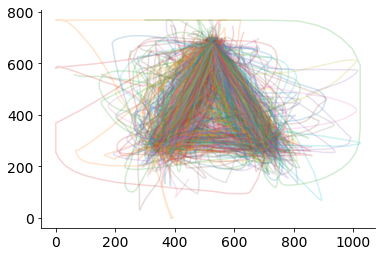

In [4]:
for trial in data.index.unique()[:1000]:
    trajectory = data.loc[trial]
    plt.plot(trajectory.x, trajectory.y, alpha=0.2)

The screen dimensions were 1024x768 pixels. Given that participants started their response from the bottom center of the screen, it seems that the origin (0,0) is actually in the top left corner (unlike the plot above). Let's transform the coordinate system so that the trajectories, when plotted, go from bottom to top.  Also, we center the x-coordinates of the trajectories around zero.

In [5]:
data['x'] = data['x'] - 1024/2
data['y'] = 768 - data['y']

Just checking that this helped:

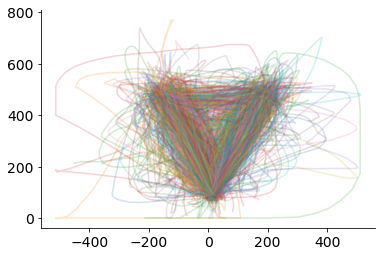

In [6]:
for trial in data.index.unique()[:1000]:
    trajectory = data.loc[trial]
    plt.plot(trajectory.x, trajectory.y, alpha=0.2)

Now let's prepare some mouse-tracking measures, starting with maximum deviation (`max_d`) and time when deviation reached maximum (relative to trajectory duration, `rel_t_max_d`). We'll also keep index of max-d (`idx_max_d`) just in case.

In [7]:
def get_maxd(traj):
    alpha = np.arctan((traj.y.iloc[-1]-traj.y.iloc[0])/ \
                        (traj.x.iloc[-1]-traj.x.iloc[0]))
    d = (traj.x.values-traj.x.values[0])*np.sin(-alpha) + \
        (traj.y.values-traj.y.values[0])*np.cos(-alpha)
    if abs(d.min())>abs(d.max()):
        max_d = d.min()
        idx_max_d = d.argmin()
    else:
        max_d = d.max()
        idx_max_d = d.argmax()
        
    return pd.Series({'max_d': max_d, 'idx_max_d': idx_max_d, 'rel_t_max_d': idx_max_d/len(traj)})

mt_measures = data.groupby(['participant', 'trial_no']).apply(get_maxd)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  


In [9]:
mt_measures.max_d.describe()

count    15596.000000
mean        34.567463
std        115.290565
min       -592.985431
25%        -29.956237
50%         25.134047
75%         73.923022
max        724.794040
Name: max_d, dtype: float64

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


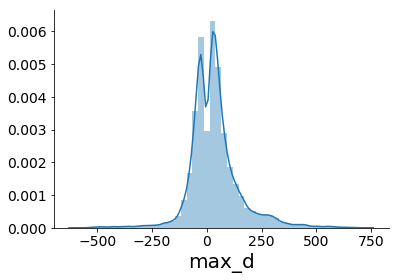

In [15]:
sns.distplot(mt_measures.max_d[mt_measures.max_d>-1000]);

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


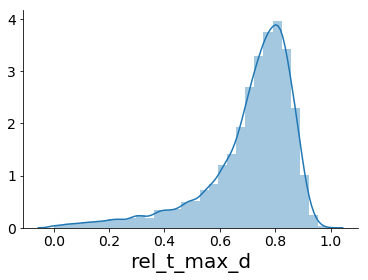

In [16]:
sns.distplot(mt_measures.rel_t_max_d, bins=30);

NB: I opted for max-d in favor of area under curve (AUC) because it works better for trajectories with loops, but generally the two are highly correlated.

To analyze trials involving changes-of-mind (CoM), it's useful to have `midline_d` metric, which measures how far the trajectory reached towards the non-chosen option. 

In [17]:
def get_midline_d(traj):
    x = traj.x.values
    midline_d, idx_midline_d, rel_time_midline_d, midline_d_y = 0, 0 , 0, 0
    is_final_point_positive = (x[-1]>0)
    if ((x[-1]>0) & (x<0).any()):
        midline_d = x.min()
        idx_midline_d = (x == midline_d).nonzero()[0][-1]
        midline_d_y = traj.y.values[idx_midline_d]
    elif ((x[-1]<0) & (x>0).any()):
        midline_d = x.max()
        idx_midline_d = (x == midline_d).nonzero()[0][-1]
        midline_d_y = traj.y.values[idx_midline_d]
    return pd.Series({'midline_d': abs(midline_d), 
                      'idx_midline_d': idx_midline_d,
                      'rel_t_midline_d': idx_midline_d/len(traj),
                      'midline_d_y': midline_d_y})

mt_measures = mt_measures.join(data.groupby(['participant', 'trial_no']).apply(get_midline_d))

If a trajectory does not have a CoM, its `midline_d` should theoretically be equal to zero. However, because of the random location of the click within the start button (and some other random factors), not all trajectories with `midline_d>0` are actually changes-of-mind. So we introduce an (arbitrary) threshold and assign CoM label to all trajectories whose midline_d exceeds this threshold.

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


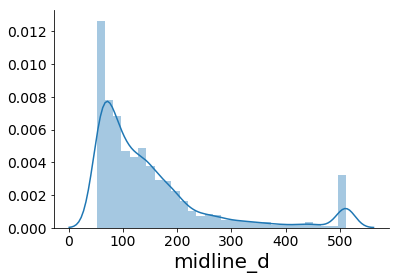

In [18]:
midline_d_threshold = 50
mt_measures['is_com'] = (mt_measures.midline_d > midline_d_threshold)
sns.distplot(mt_measures[mt_measures.is_com].midline_d, bins=30);

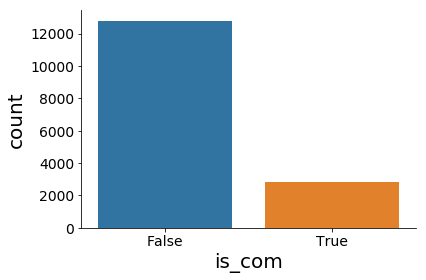

In [19]:
sns.countplot(mt_measures.is_com);

To calculate x-flips (number of changes in the sign of x-velocity), we need to numerically compute time derivatives of the mouse coordinate. Mouse velocities also might come handy in future, so we'll keep it along with the data. 

In [20]:
def differentiate(t, x):
    # To be able to reasonably calculate derivatives at the end-points of the trajectories,
    # I append three extra points before and after the actual trajectory, so we get N+6
    # points instead of N       
    x = np.append(x[0]*np.ones(3), np.append(x, x[-1]*np.ones(3)))

    # Time vector is also artificially extended by equally spaced points
    # Use median timestep to add dummy points to the time vector
    timestep = np.median(np.diff(t))
    t = np.append(t[0]-np.arange(1,4)*timestep, np.append(t, t[-1]+np.arange(1,4)*timestep))

    # smooth noise-robust differentiators, see: 
    # http://www.holoborodko.com/pavel/numerical-methods/ \
    # numerical-derivative/smooth-low-noise-differentiators/#noiserobust_2
    v = (1*(x[6:]-x[:-6])/((t[6:]-t[:-6])/6) + 
         4*(x[5:-1] - x[1:-5])/((t[5:-1]-t[1:-5])/4) + 
         5*(x[4:-2] - x[2:-4])/((t[4:-2]-t[2:-4])/2))/32

    return v

def get_derivatives(data):
    names = {'x': 'vx', 'y': 'vy'}      

    for col_name, der_name in names.items():
        data[der_name] = np.concatenate(
                [differentiate(traj['t'].values, traj[col_name].values) 
                        for traj_id, traj in data.groupby(level=['participant', 'trial_no'], group_keys=False)]
                )
    return data

data = get_derivatives(data)

In [21]:
mt_measures['x_flips'] = data.groupby(level=['participant', 'trial_no']).\
                        apply(lambda traj: (abs(np.diff(np.sign(traj.vx.values)[np.nonzero(np.sign(traj.vx))]))>1).sum())  

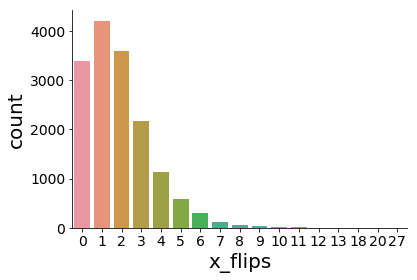

In [22]:
sns.countplot(mt_measures.x_flips);

Finally, we save the data with derivatives to a new file, and also save to a separate file all the measures we derived.

In [23]:
data.to_csv(os.path.join(measures_data_path, 'all_mouse_data.csv'), index=True)
mt_measures.to_csv(os.path.join(measures_data_path, 'mt_measures.csv'), index=True)

# NB

These measures are quite rough, mostly because there are trajectories which don't conform to the expected pattern (e.g., trajectories sometimes start in unexpected places in participants 11, 12, 14). However, for the vast majority of the trajectories, these measures should work.

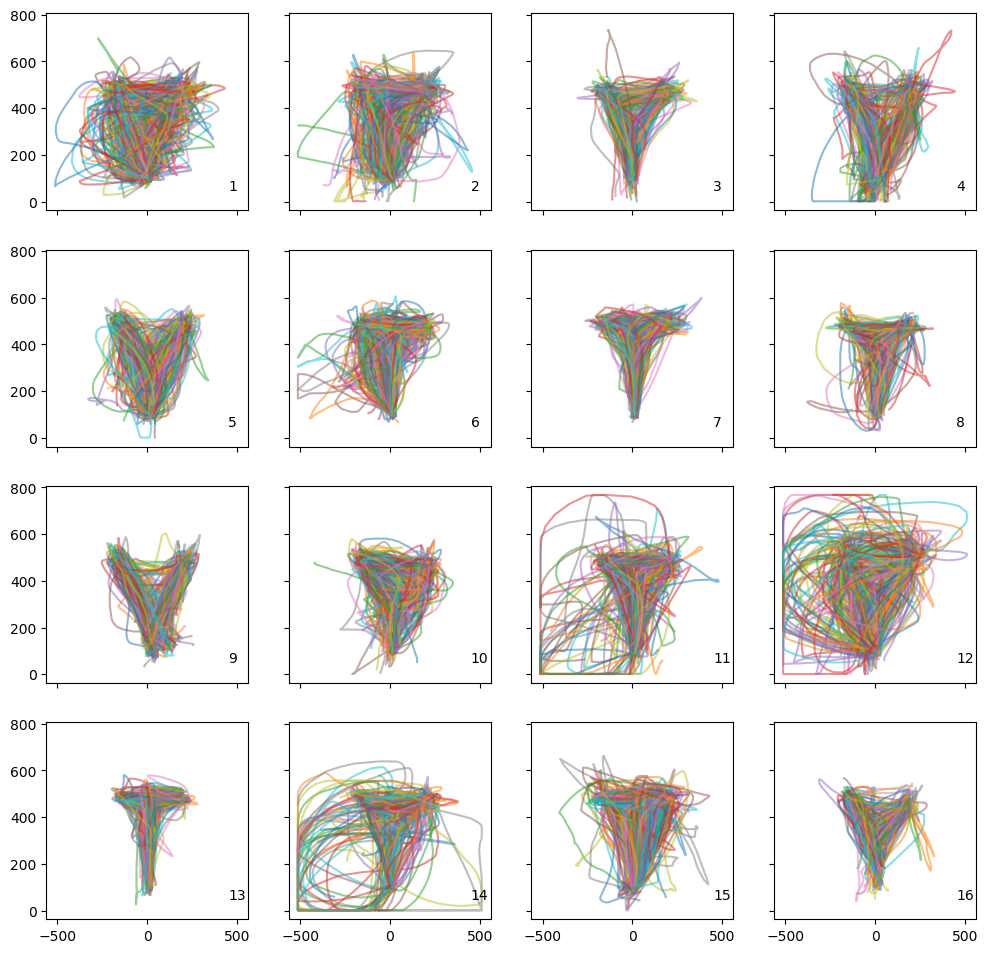

In [17]:
fig, axes = plt.subplots(4, 4, figsize=(12,12), sharex=True, sharey=True)
for participant in data.index.get_level_values('participant').unique():
    ax = axes[int(np.floor((participant-1)/4)), participant % 4-1]
    for trial in range(1,281):
        traj = data.loc[(participant, trial)]
        ax.plot(traj.x, traj.y, alpha=0.5);
    ax.text(x=450, y=50, s=participant)

Here are some of the trials with weird trajectories: marked as changes-of-mind, but without any x-flips

In [24]:
mt_measures[(mt_measures.is_com) & (mt_measures.x_flips==0)]

max_d  idx_max_d  rel_t_max_d  midline_d  \
participant trial_no                                                  
1           10         33.770425      282.0     0.715736      126.0   
            43        -60.716926      399.0     0.624413      449.0   
            45         97.287311      371.0     0.811816      153.0   
            54         25.932450      194.0     0.570588      135.0   
            57         49.666044      196.0     0.506460       51.0   
            60         58.564249      106.0     0.400000       69.0   
            128        46.610990      177.0     0.457364       56.0   
            130        72.339715      242.0     0.691429       71.0   
            194        26.958087      296.0     0.611570      197.0   
2           9         -13.649907      376.0     0.890995       78.0   
            10        -45.067191      322.0     0.904494      122.0   
            11        -13.736812      227.0     0.632312       55.0   
            29         41.057944      351.0     0.761388       97.0   
8           7         -25.305903      674.0     0.816970       75.0   
12          85          4.784273      287.0     0.655251      150.0   
            145        35.902162      291.0     0.467095       68.0   
            168        -7.907403      184.0     0.691729      158.0   
16          12       -112.847767      209.0     0.422222      356.0   
            116       -38.737635      411.0     0.807466      105.0   
19          9          33.705680      424.0     0.824903       77.0   
            72        -15.984724      294.0     0.809917       51.0   
23          7          27.254776      387.0     0.801242       60.0   
            64        -18.791437      526.0     0.882550      134.0   
            151       -23.116895      315.0     0.844504      137.0   
24          5          18.494878      301.0     0.741379       57.0   
25          173        42.266899      344.0     0.800000       92.0   
26          51         36.525845      285.0     0.750000       59.0   
27          117        92.379038      268.0     0.699739       80.0   
28          7         -21.281398      298.0     0.741294       88.0   
            16        -22.353395      280.0     0.665083       71.0   
...                          ...        ...          ...        ...   
62          14         33.632959      335.0     0.744444      166.0   
            16        157.398695      117.0     0.326816      436.0   
            19        -23.251402       97.0     0.266484      329.0   
64          32        -37.711618      314.0     0.679654       93.0   
            184        52.307068      286.0     0.858859       67.0   
65          31         29.564191      272.0     0.685139      109.0   
            51         13.852724      346.0     0.850123      131.0   
            68         72.621412      381.0     0.817597       54.0   
            78         92.710792      378.0     0.819957      121.0   
            125       -21.009173      388.0     0.832618       53.0   
            162       -23.310477      482.0     0.892593       81.0   
66          196      -154.161558      261.0     0.470270      130.0   
67          122       -23.065494      362.0     0.740286       53.0   
69          46         54.859568      365.0     0.751029       80.0   
73          81         -9.093646      503.0     0.909584       83.0   
            108        32.589724      176.0     0.442211       53.0   
75          130         6.069136      297.0     0.746231       57.0   
            155        -2.820428      247.0     0.697740      175.0   
            160        22.303203      524.0     0.778603      162.0   
            193       -17.081393      324.0     0.848168      175.0   
77          150         3.323508      449.0     0.858509       51.0   
80          92         67.507709      338.0     0.689796       76.0   
            117        -2.656066      278.0     0.850153       58.0   
            140       171.286997       42.0     0.1

And this is an example of such trajectory. We have to decide what to do with these, and if we want to exclude them, what should the exclusion criteria be.

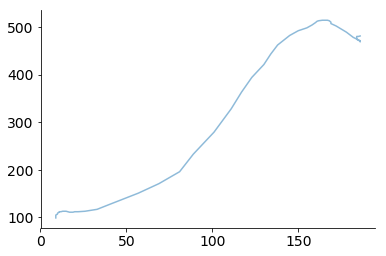

In [25]:
traj = data.loc[(14, 192)]
plt.plot(traj.x, traj.y, alpha=0.5);